In [298]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from datetime import datetime
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import PowerTransformer
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer

In [299]:
products = pd.read_csv("data/product.csv", sep='\t')
sessions = pd.read_csv("data/session.csv", sep='\t')
users = pd.read_csv("data/user.csv", sep='\t')

Vyriešené chyby z predchádzajúcej fázy

In [300]:
users = users.drop_duplicates(subset='user_id', keep='first')
users['race'] = users['race'].fillna('unspecified')
users['birthdate'] = pd.to_datetime(users['birthdate'], errors='coerce')
sessions['ack']=sessions['ack'].astype(int)
duplikatne_riadky = sessions[sessions.duplicated()]
sessions.drop_duplicates(inplace=True)
sessions['session_start'] = pd.to_datetime(sessions['session_start'], errors='coerce')

In [301]:
products.head()

,code,location,store_name,product_ean
0,HR,Europe/Zagreb,Split,3618641987900
1,CN,Asia/Shanghai,Heyuan,890698872559
2,NL,Europe/Amsterdam,Barneveld,2447491624236
3,MX,America/Mexico_City,Tuxtla,2920947188549
4,US,America/New_York,Sun City Center,4869841703558


In [302]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14962 entries, 0 to 14961
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   code         14948 non-null  object
 1   location     14962 non-null  object
 2   store_name   14962 non-null  object
 3   product_ean  14962 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 467.7+ KB


In [303]:
sessions.head()

,pct_wild_mouse,screen_height,pct_input,pct_scrandom,pct_scroll_move,pct_click_product_info,wild_mouse_duration,session_start,total_load_time,pct_click,...,session_id,pct_scroll_move_duration,ack,scroll_move_total_rel_distance,page_activity_duration,mouse_move_total_rel_distance,browser_name,pct_rage_click,session_duration,pct_mouse_click
0,33.93175,600,2.02433,47.57172,77.67966,50.06169,16.15405,2022-04-16 18:13:19,3.66109,15.21849,...,341891,17.64845,0,13.31028,15.50704,16.78128,safari,73.88232,93.50794,NaN
1,35.01962,768,2.73613,44.98978,40.38256,53.78582,16.44725,2022-09-07 09:34:07,3.06183,17.79744,...,1302699,16.90542,1,18.33657,15.76245,16.67535,firefox,36.27018,83.05534,15.63971
2,61.41151,800,2.30551,56.16179,29.32719,61.74431,16.28032,2022-08-01 19:22:50,4.30491,16.56530,...,1346090,20.42301,1,7.24767,15.94806,17.84916,opera,44.07316,212.16973,13.54653
3,44.86510,600,4.67376,51.02882,57.35852,44.10727,16.97307,2020-03-28 06:00:21,2.66177,14.10738,...,320000,19.13251,0,9.27093,17.21545,15.85436,edge,61.91555,62.13615,14.83673
4,61.66559,800,6.29241,33.35663,50.05876,36.03935,17.26692,2023-02-12 18:25:13,3.67287,19.04736,...,291366,13.65667,0,19.71573,17.01892,16.65385,chrome,21.36066,157.60814,15.17088


In [304]:
sessions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10962 entries, 0 to 11093
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   pct_wild_mouse                  10951 non-null  float64       
 1   screen_height                   10962 non-null  object        
 2   pct_input                       10951 non-null  float64       
 3   pct_scrandom                    10951 non-null  float64       
 4   pct_scroll_move                 10951 non-null  float64       
 5   pct_click_product_info          10951 non-null  float64       
 6   wild_mouse_duration             10951 non-null  float64       
 7   session_start                   10962 non-null  datetime64[ns]
 8   total_load_time                 10962 non-null  float64       
 9   pct_click                       10951 non-null  float64       
 10  screen_width                    10962 non-null  object        
 11  pct_dou

In [305]:
users.head()

,username,residence,current_location,name,mail,job,sex,race,address,birthdate,user_id
0,gabrieladas-neves,NaN,"(Decimal('-37.802134'), Decimal('79.453092'))",Sabrina da Luz,xda-cunha@yahoo.com.br,Engenheiro aeronáutico,NaN,unspecified,"Condomínio de Silva, 16\nNovo Ouro Preto\n6891...",NaT,640
1,ferreirajulia,NaN,"(Decimal('4.633756'), Decimal('102.063245'))",Maria Vitória Mendes,catarinada-conceicao@gmail.com,Mãe social,F,black,"Campo Eloah Ribeiro, 66\nEstrela Do Oriente\n2...",1946-06-27,1222
2,isadora80,NaN,"(Decimal('80.9854585'), Decimal('135.043616'))",Isabella Nascimento,maria-sophiasouza@ig.com.br,NaN,NaN,unspecified,Viela da Luz\nConjunto Santa Maria\n92354128 A...,1940-12-01,298
3,adriana04,NaN,"(Decimal('67.6271835'), Decimal('-41.336778'))",Daria Boldù,ngaleati@alice.it,NaN,NaN,unspecified,"Vicolo Sophia, 452 Piano 7\n26843, Meleti (LO)",1958-02-01,316
4,kellygreg,NaN,"(Decimal('39.336945'), Decimal('120.879401'))",Sandra Jenkins,danieljordan@yahoo.com,Fine artist,NaN,unspecified,31740 Maria Stravenue Apt. 240\nLake Rodneyfur...,1997-05-26,1992


In [306]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1594 entries, 0 to 2536
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   username          1594 non-null   object        
 1   residence         553 non-null    object        
 2   current_location  1509 non-null   object        
 3   name              1594 non-null   object        
 4   mail              1594 non-null   object        
 5   job               635 non-null    object        
 6   sex               777 non-null    object        
 7   race              1594 non-null   object        
 8   address           1354 non-null   object        
 9   birthdate         903 non-null    datetime64[ns]
 10  user_id           1594 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(9)
memory usage: 149.4+ KB


Po skúšaní spojiť session s product som prisšla k zisteniu, že product_ean sa nezhodujú, takže sa tie dva datasety nedajú spojiť. Nevidím žiadne logické riešenie ako by sa to dalo napraviť. Takže budem spájať a následne pracovať iba s users a sessions.

In [307]:
merged_data = pd.merge(sessions, users, on='user_id', how='left')
merged_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10962 entries, 0 to 10961
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   pct_wild_mouse                  10951 non-null  float64       
 1   screen_height                   10962 non-null  object        
 2   pct_input                       10951 non-null  float64       
 3   pct_scrandom                    10951 non-null  float64       
 4   pct_scroll_move                 10951 non-null  float64       
 5   pct_click_product_info          10951 non-null  float64       
 6   wild_mouse_duration             10951 non-null  float64       
 7   session_start                   10962 non-null  datetime64[ns]
 8   total_load_time                 10962 non-null  float64       
 9   pct_click                       10951 non-null  float64       
 10  screen_width                    10962 non-null  object        
 11  pc

*Ako prvé idem vymatať stlpce, ktoré sú mi zbytočné*</br>
Vyrobila som si stlpec age (nahradila som aj chýbajúce hodnoty priemerom) pomocou stlpca birthday, ktorý následne budem vymazávať

In [308]:
merged_data['age'] = ((datetime.now() - merged_data['birthdate']).dt.days / 365.25)
merged_data['age'] = merged_data['age'].round()
mean_age = merged_data['age'].mean()
merged_data['age'].fillna(mean_age, inplace=True)
merged_data['age'] = merged_data['age'].round().astype(int)

merged_data.head()

,pct_wild_mouse,screen_height,pct_input,pct_scrandom,pct_scroll_move,pct_click_product_info,wild_mouse_duration,session_start,total_load_time,pct_click,...,residence,current_location,name,mail,job,sex,race,address,birthdate,age
0,33.93175,600,2.02433,47.57172,77.67966,50.06169,16.15405,2022-04-16 18:13:19,3.66109,15.21849,...,NaN,"(Decimal('65.429204'), Decimal('27.147097'))",Rebeca Silva,danielsouza@bol.com.br,Lubrificador de máquinas,NaN,unspecified,"Sítio da Luz, 777\nCarmo\n54487013 Silveira Ve...",1988-07-17,35
1,35.01962,768,2.73613,44.98978,40.38256,53.78582,16.44725,2022-09-07 09:34:07,3.06183,17.79744,...,NaN,"(Decimal('-65.9975475'), Decimal('-33.607602'))",Daria Boccaccio,francescapiane@alice.it,Sports development officer,F,unspecified,"Stretto Cammarata, 48 Appartamento 9\n44122, F...",2016-12-07,7
2,61.41151,800,2.30551,56.16179,29.32719,61.74431,16.28032,2022-08-01 19:22:50,4.30491,16.56530,...,auch Schlauchinallee 0/2\n71393 Angermünde,"(Decimal('53.467912'), Decimal('6.845211'))",Marisa Trubin,filiz70@hotmail.de,NaN,NaN,unspecified,Matthäistraße 376\n50173 Merseburg,1939-09-18,84
3,44.86510,600,4.67376,51.02882,57.35852,44.10727,16.97307,2020-03-28 06:00:21,2.66177,14.10738,...,NaN,"(Decimal('59.408055'), Decimal('129.747870'))",Igor Barbosa,rezendesofia@uol.com.br,NaN,M,unspecified,"Trevo de Gonçalves, 246\nLuxemburgo\n79216440 ...",NaT,60
4,61.66559,800,6.29241,33.35663,50.05876,36.03935,17.26692,2023-02-12 18:25:13,3.67287,19.04736,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,60


In [309]:
if 'username' in merged_data.columns:
    merged_data.drop('username', axis='columns', inplace=True)
    print("vymazanie username")
if 'residence' in merged_data.columns:
    merged_data.drop('residence', axis='columns', inplace=True)
    print("vymazanie residence")
if 'current_location' in merged_data.columns:
    merged_data.drop('current_location', axis='columns', inplace=True)
    print("vymazanie current_location")
if 'name' in merged_data.columns:
    merged_data.drop('name', axis='columns', inplace=True)
    print("vymazanie name")
if 'mail' in merged_data.columns:
    merged_data.drop('mail', axis='columns', inplace=True)
    print("vymazanie mail")
if 'address' in merged_data.columns:
    merged_data.drop('address', axis='columns', inplace=True)
    print("vymazanie address")
if 'birthdate' in merged_data.columns:
    merged_data.drop('birthdate', axis='columns', inplace=True)
    print("vymazanie birthdate")
if 'session_start' in merged_data.columns:
    merged_data.drop('session_start', axis='columns', inplace=True)
    print("vymazanie session_start")
if 'sex' in merged_data.columns:
    merged_data.drop('sex', axis='columns', inplace=True)
    print("vymazanie sex")
merged_data.head()

vymazanie username
vymazanie residence
vymazanie current_location
vymazanie name
vymazanie mail
vymazanie address
vymazanie birthdate
vymazanie session_start
vymazanie sex


,pct_wild_mouse,screen_height,pct_input,pct_scrandom,pct_scroll_move,pct_click_product_info,wild_mouse_duration,total_load_time,pct_click,screen_width,...,scroll_move_total_rel_distance,page_activity_duration,mouse_move_total_rel_distance,browser_name,pct_rage_click,session_duration,pct_mouse_click,job,race,age
0,33.93175,600,2.02433,47.57172,77.67966,50.06169,16.15405,3.66109,15.21849,1366,...,13.31028,15.50704,16.78128,safari,73.88232,93.50794,NaN,Lubrificador de máquinas,unspecified,35
1,35.01962,768,2.73613,44.98978,40.38256,53.78582,16.44725,3.06183,17.79744,1280,...,18.33657,15.76245,16.67535,firefox,36.27018,83.05534,15.63971,Sports development officer,unspecified,7
2,61.41151,800,2.30551,56.16179,29.32719,61.74431,16.28032,4.30491,16.56530,1280,...,7.24767,15.94806,17.84916,opera,44.07316,212.16973,13.54653,NaN,unspecified,84
3,44.86510,600,4.67376,51.02882,57.35852,44.10727,16.97307,2.66177,14.10738,1920,...,9.27093,17.21545,15.85436,edge,61.91555,62.13615,14.83673,NaN,unspecified,60
4,61.66559,800,6.29241,33.35663,50.05876,36.03935,17.26692,3.67287,19.04736,1024,...,19.71573,17.01892,16.65385,chrome,21.36066,157.60814,15.17088,NaN,NaN,60


Vymazali sme hodnoty, ktoré su pre každého usera jedinečné a teda nám nič nepovedia o ack, teda username, residence,e current_locatio,ie ne,nie m,anie add,zanie birt,azanie session. Dalej sme vymazali aj atribút sex, pretože má okolo 60% NaN hodnot a analyzovať ack na základe tohto atribútu by teda nebolo presné._start

In [310]:
merged_data['race'] = merged_data['race'].fillna('unspecified')
merged_data['job'] = merged_data['job'].fillna('unspecified')
merged_data.head()

,pct_wild_mouse,screen_height,pct_input,pct_scrandom,pct_scroll_move,pct_click_product_info,wild_mouse_duration,total_load_time,pct_click,screen_width,...,scroll_move_total_rel_distance,page_activity_duration,mouse_move_total_rel_distance,browser_name,pct_rage_click,session_duration,pct_mouse_click,job,race,age
0,33.93175,600,2.02433,47.57172,77.67966,50.06169,16.15405,3.66109,15.21849,1366,...,13.31028,15.50704,16.78128,safari,73.88232,93.50794,NaN,Lubrificador de máquinas,unspecified,35
1,35.01962,768,2.73613,44.98978,40.38256,53.78582,16.44725,3.06183,17.79744,1280,...,18.33657,15.76245,16.67535,firefox,36.27018,83.05534,15.63971,Sports development officer,unspecified,7
2,61.41151,800,2.30551,56.16179,29.32719,61.74431,16.28032,4.30491,16.56530,1280,...,7.24767,15.94806,17.84916,opera,44.07316,212.16973,13.54653,unspecified,unspecified,84
3,44.86510,600,4.67376,51.02882,57.35852,44.10727,16.97307,2.66177,14.10738,1920,...,9.27093,17.21545,15.85436,edge,61.91555,62.13615,14.83673,unspecified,unspecified,60
4,61.66559,800,6.29241,33.35663,50.05876,36.03935,17.26692,3.67287,19.04736,1024,...,19.71573,17.01892,16.65385,chrome,21.36066,157.60814,15.17088,unspecified,unspecified,60


Doplnenie chýbajúcich hodnôt do objektových atribútov</br>
Race má už v pôvodných dátach hodnotu 'unspecified' a v tomto kontexte je to isté ako NaN, tak všetky NaN hodnoty tým nahradíme. V atribúte jobs sa nachádza veľké množstvo NaN hodnôt a veľa rozličných druhov prác, takže by nebolo logické to nahradzovať napríklad pomerom prác, takže použijeme znova označenie 'unspecified'. Ziaden pocet NaN v spomýnaných atribútov vyššie nebol natoľko nízky, aby sme si ich mohli dovoliť vymazať. Ďalšie objektové atribúty nemajú NaN hodnoty 

In [311]:
ce_ordinal = ce.OrdinalEncoder(cols=['race'])
merged_data= ce_ordinal.fit_transform(merged_data)
ce_ordinal = ce.OrdinalEncoder(cols=['job'])
merged_data= ce_ordinal.fit_transform(merged_data)
ce_ordinal = ce.OrdinalEncoder(cols=['browser_name'])
merged_data= ce_ordinal.fit_transform(merged_data)
ce_ordinal = ce.OrdinalEncoder(cols=['screen_height'])
merged_data= ce_ordinal.fit_transform(merged_data)
ce_ordinal = ce.OrdinalEncoder(cols=['screen_width'])
merged_data= ce_ordinal.fit_transform(merged_data)
merged_data.head()

,pct_wild_mouse,screen_height,pct_input,pct_scrandom,pct_scroll_move,pct_click_product_info,wild_mouse_duration,total_load_time,pct_click,screen_width,...,scroll_move_total_rel_distance,page_activity_duration,mouse_move_total_rel_distance,browser_name,pct_rage_click,session_duration,pct_mouse_click,job,race,age
0,33.93175,1,2.02433,47.57172,77.67966,50.06169,16.15405,3.66109,15.21849,1,...,13.31028,15.50704,16.78128,1,73.88232,93.50794,NaN,1,1,35
1,35.01962,2,2.73613,44.98978,40.38256,53.78582,16.44725,3.06183,17.79744,2,...,18.33657,15.76245,16.67535,2,36.27018,83.05534,15.63971,2,1,7
2,61.41151,3,2.30551,56.16179,29.32719,61.74431,16.28032,4.30491,16.56530,2,...,7.24767,15.94806,17.84916,3,44.07316,212.16973,13.54653,3,1,84
3,44.86510,1,4.67376,51.02882,57.35852,44.10727,16.97307,2.66177,14.10738,3,...,9.27093,17.21545,15.85436,4,61.91555,62.13615,14.83673,3,1,60
4,61.66559,3,6.29241,33.35663,50.05876,36.03935,17.26692,3.67287,19.04736,4,...,19.71573,17.01892,16.65385,5,21.36066,157.60814,15.17088,3,1,60


Následne objectové atribúty zmeníme na číselne pomocou Ordinal Encoding

In [312]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10962 entries, 0 to 10961
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   pct_wild_mouse                  10951 non-null  float64
 1   screen_height                   10962 non-null  int64  
 2   pct_input                       10951 non-null  float64
 3   pct_scrandom                    10951 non-null  float64
 4   pct_scroll_move                 10951 non-null  float64
 5   pct_click_product_info          10951 non-null  float64
 6   wild_mouse_duration             10951 non-null  float64
 7   total_load_time                 10962 non-null  float64
 8   pct_click                       10951 non-null  float64
 9   screen_width                    10962 non-null  int64  
 10  pct_doubleclick                 10951 non-null  float64
 11  product_ean                     10962 non-null  int64  
 12  pct_mouse_move                  

In [313]:
means = merged_data.mean()
merged_data = merged_data.fillna(means)
merged_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10962 entries, 0 to 10961
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   pct_wild_mouse                  10962 non-null  float64
 1   screen_height                   10962 non-null  int64  
 2   pct_input                       10962 non-null  float64
 3   pct_scrandom                    10962 non-null  float64
 4   pct_scroll_move                 10962 non-null  float64
 5   pct_click_product_info          10962 non-null  float64
 6   wild_mouse_duration             10962 non-null  float64
 7   total_load_time                 10962 non-null  float64
 8   pct_click                       10962 non-null  float64
 9   screen_width                    10962 non-null  int64  
 10  pct_doubleclick                 10962 non-null  float64
 11  product_ean                     10962 non-null  int64  
 12  pct_mouse_move                  

Dalej sme nahradili číselné hodnoty (tie, čo pred tým neboli object) priemerom

/Users/markbartalos/.virtualenvs/iau/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/markbartalos/.virtualenvs/iau/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/markbartalos/.virtualenvs/iau/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/markbartalos/.virtualenvs/iau/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed i

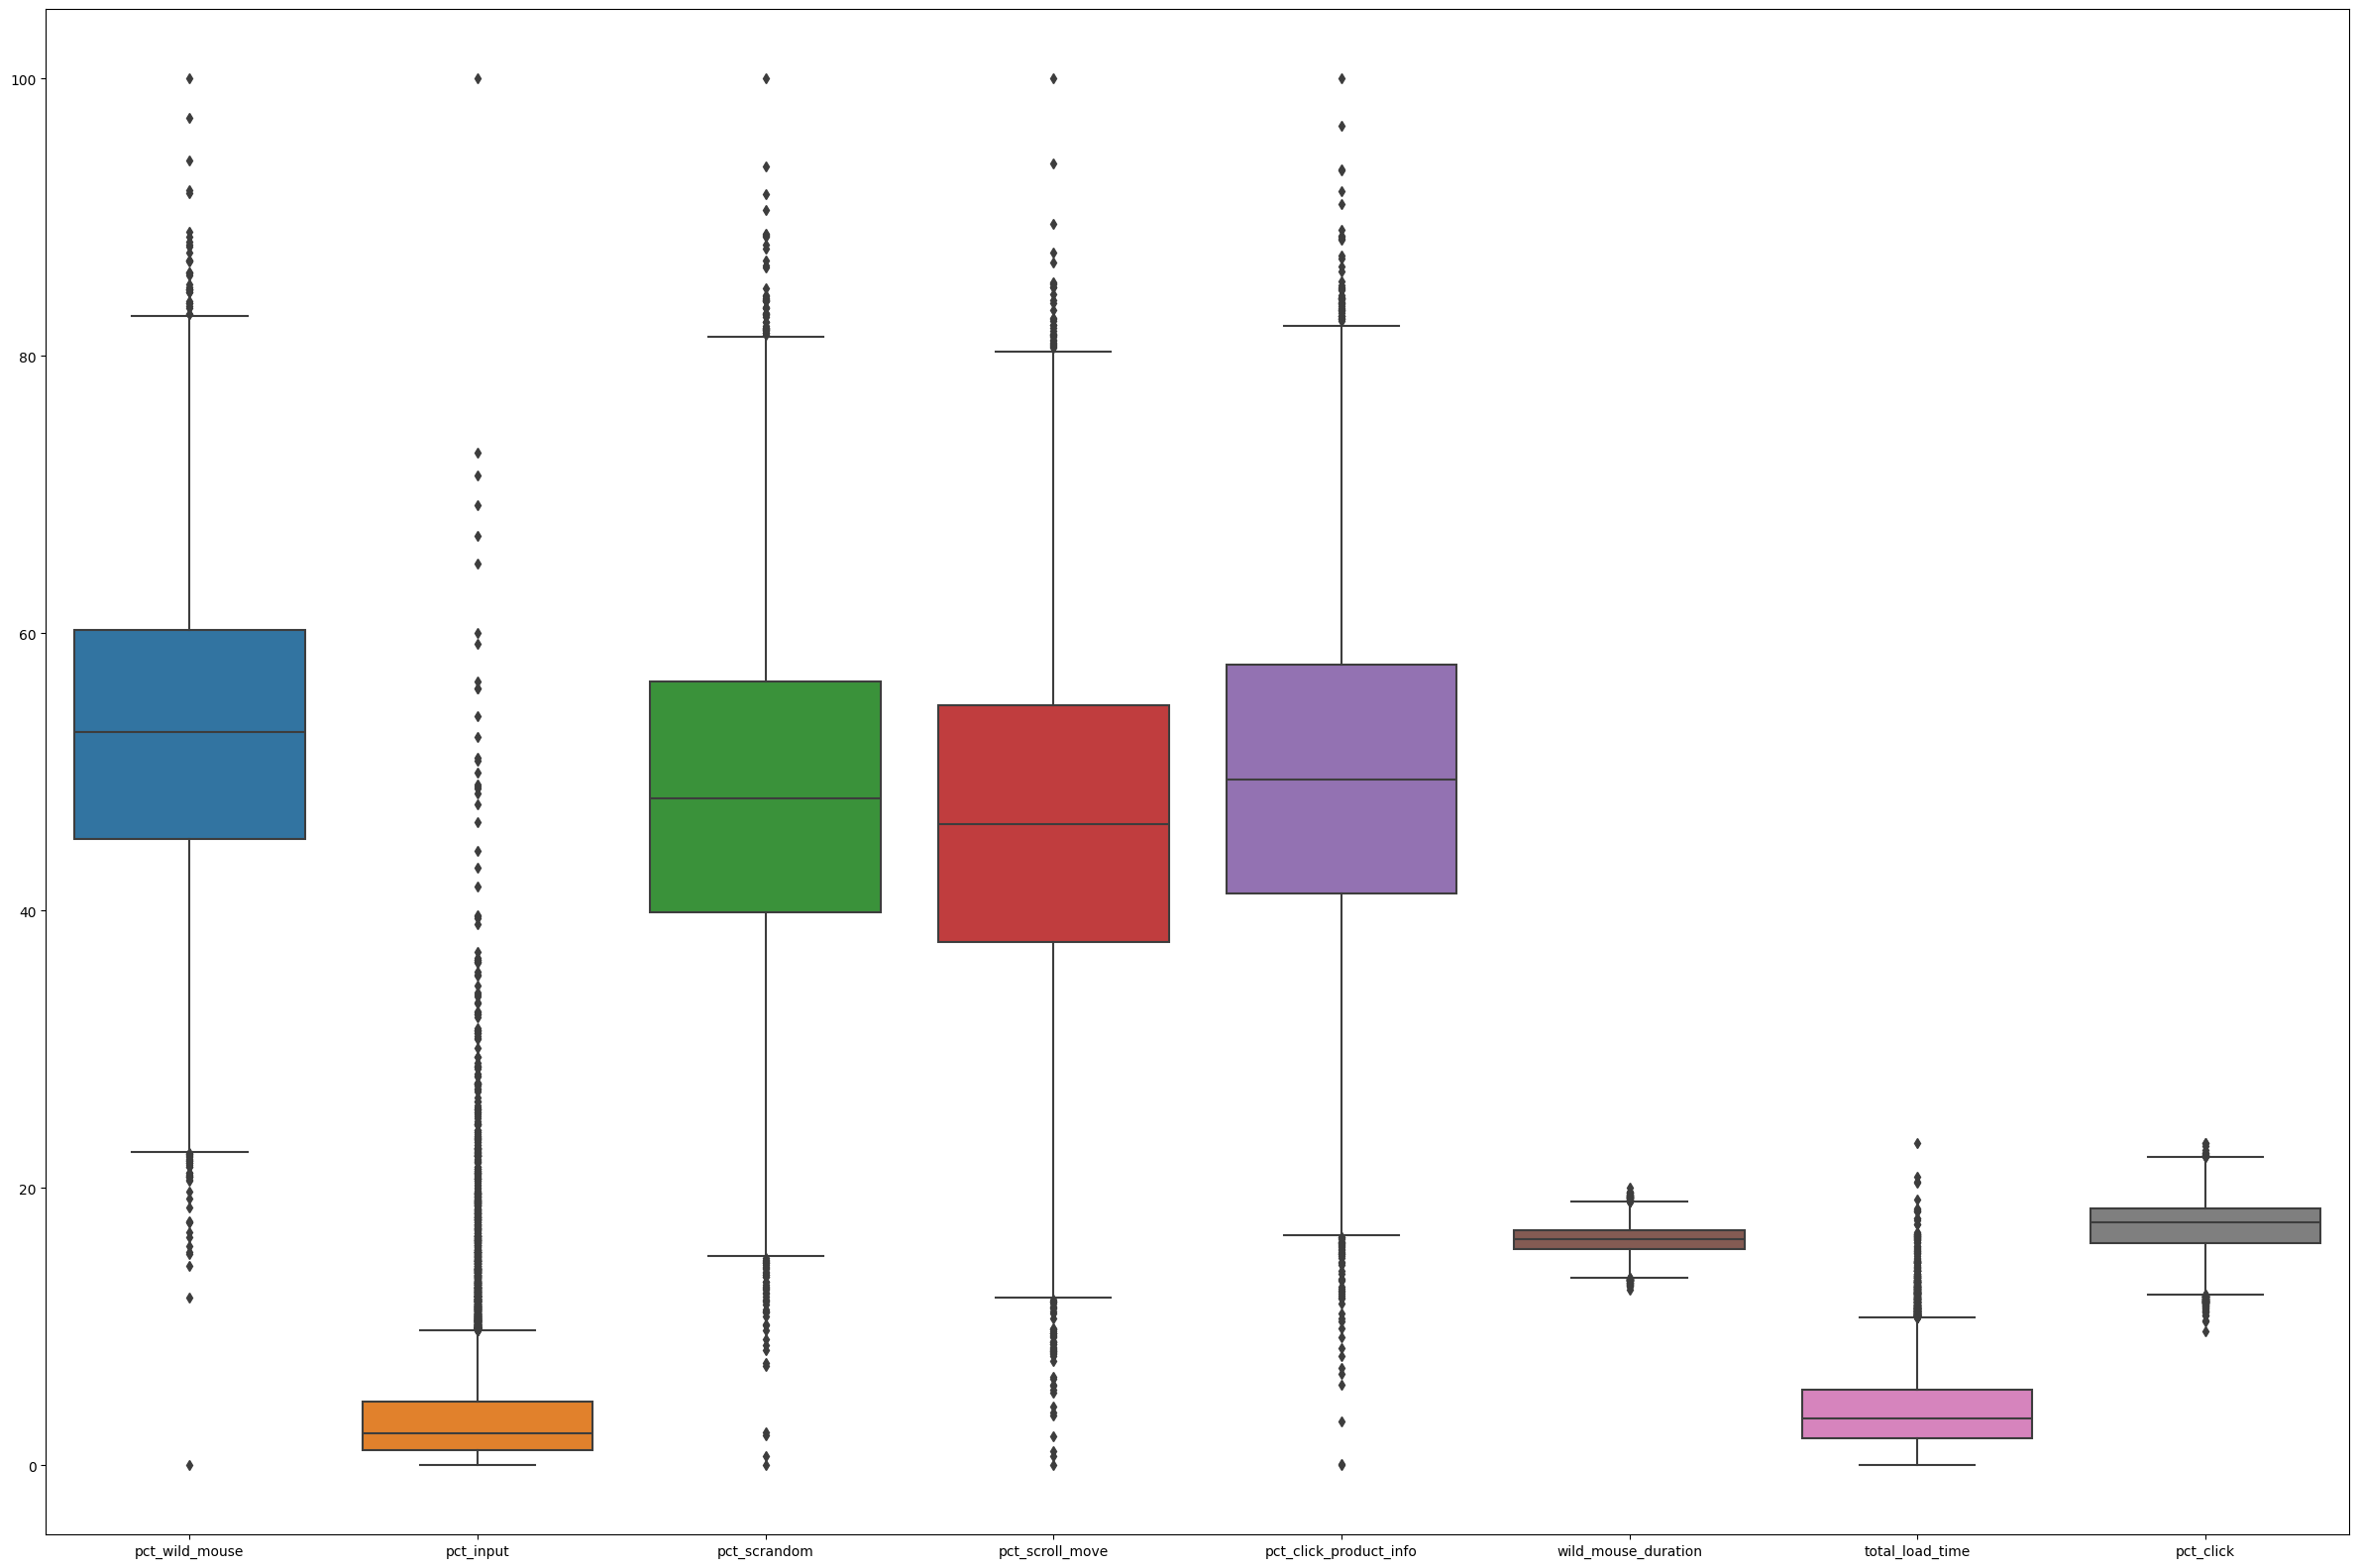

In [314]:
fig, ax = plt.subplots(figsize=(30, 20))
sns.boxplot(data=merged_data[['pct_wild_mouse', 'pct_input', 'pct_scrandom', 'pct_scroll_move', 'pct_click_product_info', 'wild_mouse_duration', 'total_load_time', 'pct_click']])
plt.show()

/Users/markbartalos/.virtualenvs/iau/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/markbartalos/.virtualenvs/iau/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/markbartalos/.virtualenvs/iau/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/markbartalos/.virtualenvs/iau/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed i

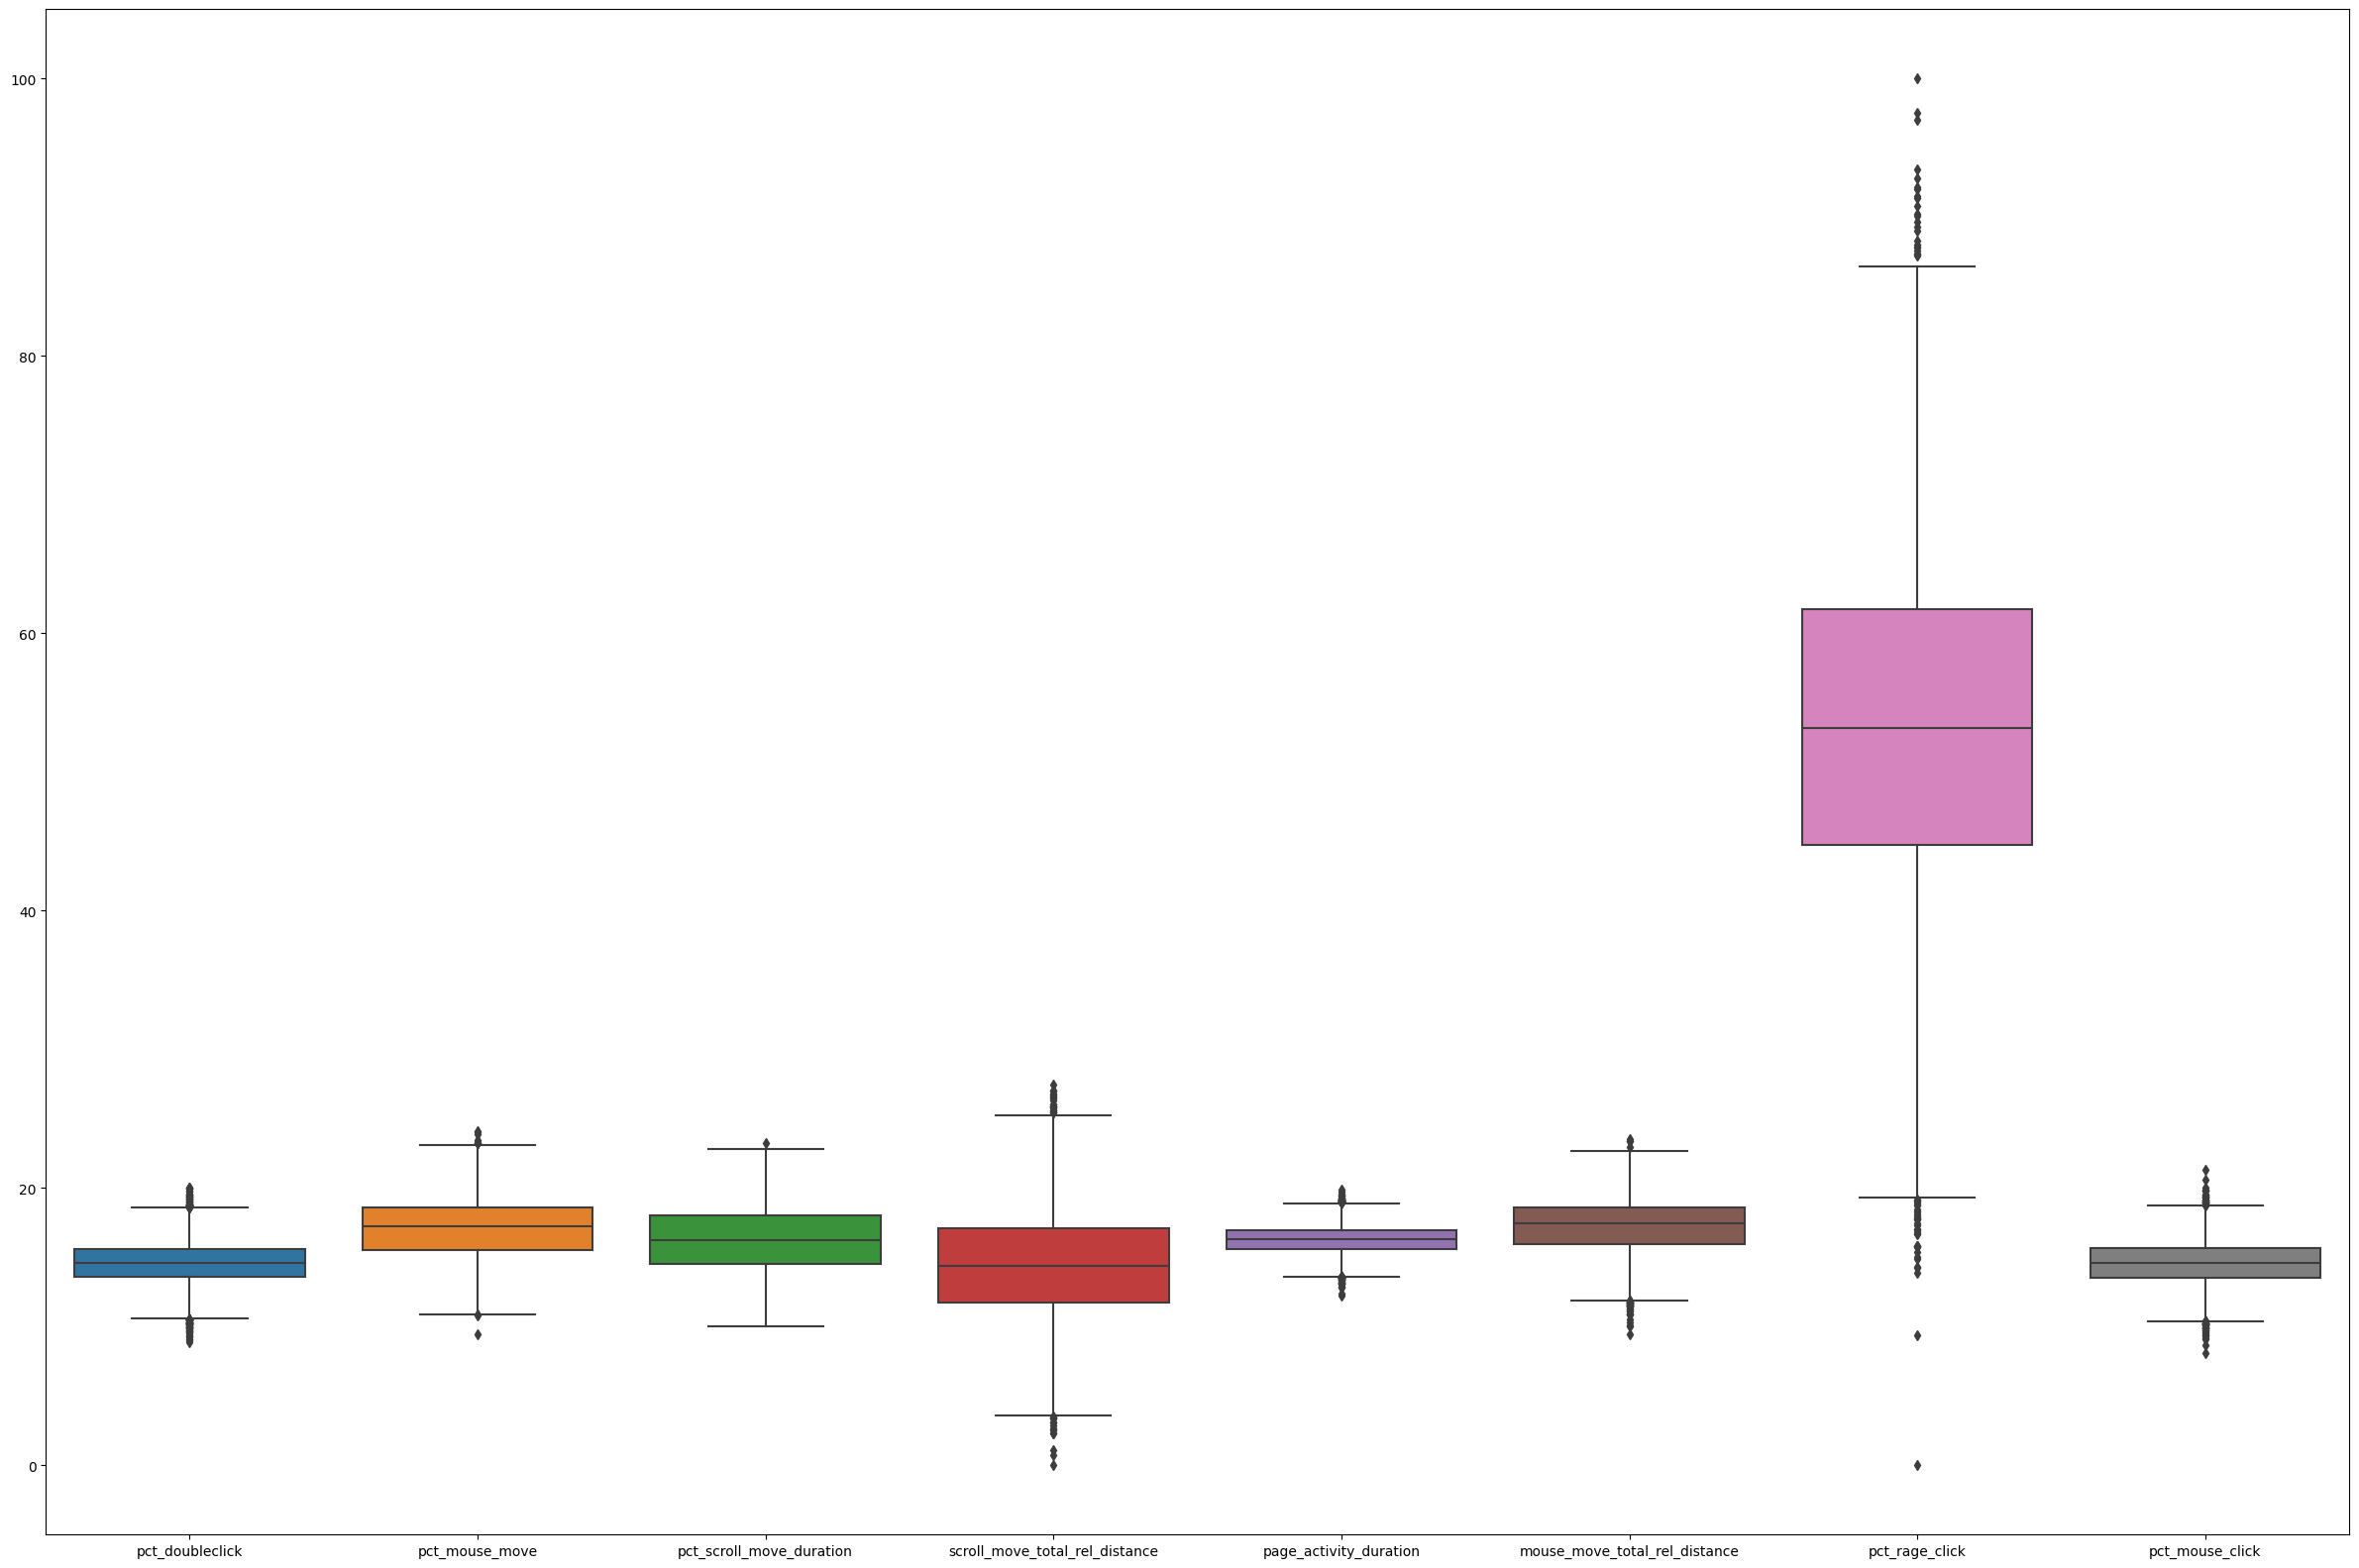

In [315]:
fig, ax = plt.subplots(figsize=(30, 20))
sns.boxplot(data=merged_data[['pct_doubleclick', 'pct_mouse_move', 'pct_scroll_move_duration', 'scroll_move_total_rel_distance', 'page_activity_duration', 'mouse_move_total_rel_distance', 'pct_rage_click', 'pct_mouse_click']])
plt.show()

Na grafoch môžeme vidieť, že atribúty majú outlierov. Niektoré viac, niektoré menej. V grafe som obsiahla všetky atribúty, ktorých atribúty by bolo potrebné ošetriť na outlierov (ešte session duration, ale to som nedávala do grafu, lebo má veľké hodnoty oproti ostatným atribútom a nie je dobre vidieť potom ostatné)


In [316]:
#Funkcia prevzatá zo vzorových notebookov
def identify_outliers(a):
    lower = a.quantile(0.25) - 1.5 * stats.iqr(a)
    upper = a.quantile(0.75) + 1.5 * stats.iqr(a)
    
    return a[(a > upper) | (a < lower)]

In [317]:
def delete_outliers(merged_data):
    count=0
    pocet_zaznamov_na_zaciatku=merged_data.shape[0]
    for column in merged_data[['pct_doubleclick', 'pct_mouse_move', 'pct_scroll_move_duration', 'scroll_move_total_rel_distance', 'page_activity_duration', 'mouse_move_total_rel_distance', 'pct_rage_click', 'pct_mouse_click', 'pct_wild_mouse', 'pct_input', 'pct_scrandom', 'pct_scroll_move', 'pct_click_product_info', 'wild_mouse_duration', 'total_load_time', 'pct_click', 'session_duration']]:
        outliers = identify_outliers(merged_data[column])
        count+=outliers.count()
        merged_data=merged_data.drop(outliers.index)

    print(f'Počet vychýlených hodnôt je {count}')
    print(f'Percento zaznamov, ktore ostali v percentach: {merged_data.shape[0]*100/pocet_zaznamov_na_zaciatku}')
    return merged_data

In [318]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10962 entries, 0 to 10961
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   pct_wild_mouse                  10962 non-null  float64
 1   screen_height                   10962 non-null  int64  
 2   pct_input                       10962 non-null  float64
 3   pct_scrandom                    10962 non-null  float64
 4   pct_scroll_move                 10962 non-null  float64
 5   pct_click_product_info          10962 non-null  float64
 6   wild_mouse_duration             10962 non-null  float64
 7   total_load_time                 10962 non-null  float64
 8   pct_click                       10962 non-null  float64
 9   screen_width                    10962 non-null  int64  
 10  pct_doubleclick                 10962 non-null  float64
 11  product_ean                     10962 non-null  int64  
 12  pct_mouse_move                  

In [319]:

merged_data = delete_outliers(merged_data)
merged_data.info()

Počet vychýlených hodnôt je 2014
Percento zaznamov, ktore ostali v percentach: 81.6274402481299
<class 'pandas.core.frame.DataFrame'>
Index: 8948 entries, 0 to 10961
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   pct_wild_mouse                  8948 non-null   float64
 1   screen_height                   8948 non-null   int64  
 2   pct_input                       8948 non-null   float64
 3   pct_scrandom                    8948 non-null   float64
 4   pct_scroll_move                 8948 non-null   float64
 5   pct_click_product_info          8948 non-null   float64
 6   wild_mouse_duration             8948 non-null   float64
 7   total_load_time                 8948 non-null   float64
 8   pct_click                       8948 non-null   float64
 9   screen_width                    8948 non-null   int64  
 10  pct_doubleclick                 8948 non-null   float64
 11  pro

Vymazanie outlierov, zistili sme, že skoro 20% dát sme stratili

In [320]:
def delete_outliers_quantile(merged_data):
    count=0
    for column in merged_data[['pct_doubleclick', 'pct_mouse_move', 'pct_scroll_move_duration', 'scroll_move_total_rel_distance', 'page_activity_duration', 'mouse_move_total_rel_distance', 'pct_rage_click', 'pct_mouse_click', 'pct_wild_mouse', 'pct_input', 'pct_scrandom', 'pct_scroll_move', 'pct_click_product_info', 'wild_mouse_duration', 'total_load_time', 'pct_click', 'session_duration']]:
        outliers = identify_outliers(merged_data[column])
        lower_q = merged_data[column].quantile(0.05)
        uper_q = merged_data[column].quantile(0.95)
        count+=outliers.count()
        merged_data[column] = merged_data[column].clip(lower_q, uper_q)
        
    print(f'Počet zmenenych hodnôt je {count}')
    return merged_data



In [321]:
#merged_data = delete_outliers_quantile(merged_data)
#merged_data.info()

Alternatíva pre outlierov je, že ich nahradím hraničnými hodnotami, teda quantilom 0.05 alebo 0.95

# 2. Predspracovanie dat

We split the data into 2 different sets of data one will be for training and the other part will be for testing the predicted results. The training part will be 80% of the data and the testing part will be the 20% of the complete data.

In [322]:
features = merged_data.drop('ack', axis=1)
target = merged_data['ack']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

X_train

,pct_wild_mouse,screen_height,pct_input,pct_scrandom,pct_scroll_move,pct_click_product_info,wild_mouse_duration,total_load_time,pct_click,screen_width,...,scroll_move_total_rel_distance,page_activity_duration,mouse_move_total_rel_distance,browser_name,pct_rage_click,session_duration,pct_mouse_click,job,race,age
9326,57.65601,5,1.16775,31.05366,75.03575,40.50160,15.62633,1.93104,14.51268,5,...,9.90963,15.77853,13.28226,3,23.49009,64.32872,11.82479,3,1,84
6986,53.20554,1,4.03700,42.57398,66.77075,28.88212,16.82874,5.17281,18.12052,2,...,13.72969,17.33340,17.15487,5,43.50684,165.46769,15.66504,3,1,60
3621,32.08738,2,1.12728,45.43745,52.70110,34.58205,15.59301,5.03297,18.33731,2,...,13.87142,15.33240,19.53838,4,52.84745,50.53015,13.69734,120,1,12
3637,59.44242,4,1.22600,42.07027,27.92109,27.66239,15.67245,5.70022,17.96591,7,...,15.78900,16.64294,18.89060,2,49.14594,186.58193,14.76433,3,1,60
9865,79.27181,5,0.68271,76.89111,61.08636,22.03654,15.12626,10.24121,20.48074,3,...,17.32169,16.81626,19.61759,4,32.02144,200.62330,16.36232,3,1,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7028,37.69758,5,6.67999,35.91832,36.30834,45.42789,17.32608,3.63522,19.52320,6,...,15.92570,16.15766,18.51539,5,55.63218,112.72287,14.79973,3,1,60
6369,47.32132,3,5.07519,35.73671,55.40893,62.39464,17.05438,0.94554,17.66598,2,...,14.19886,15.58098,19.56023,4,45.32908,184.86381,15.03829,3,1,60
6603,65.31653,6,0.45117,63.27280,53.17940,54.45418,14.75556,3.77690,17.53160,4,...,11.32240,15.53329,18.24384,4,73.10340,165.81022,10.77610,3,1,60
1057,78.75737,7,0.48053,45.92923,50.20358,49.03628,14.81084,2.30610,13.80669,3,...,13.23998,16.58841,13.74976,5,56.71765,84.42132,15.73600,3,1,91


### Encoding

All useful text columns were encoded in the previous section using ordinal encoding where different text categories were encoded into numbers where each category was given a unique number.

### Skalovanie


We normalize the data using the MinMaxScaler. We use the MinMaxScaler because this scaler provides uniform scaling and ensures that no single feature dominates the model due to its scale. Also, it preserver the relationships among the original data points.

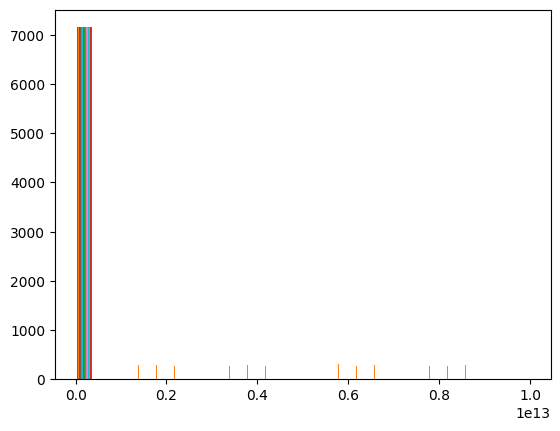

In [323]:
scaler = MinMaxScaler()
graph = pyplot.hist(X_train, bins=25)
graph.index
X_scaled = scaler.fit_transform(X_train) 

<function tuple.index(value, start=0, stop=9223372036854775807, /)>

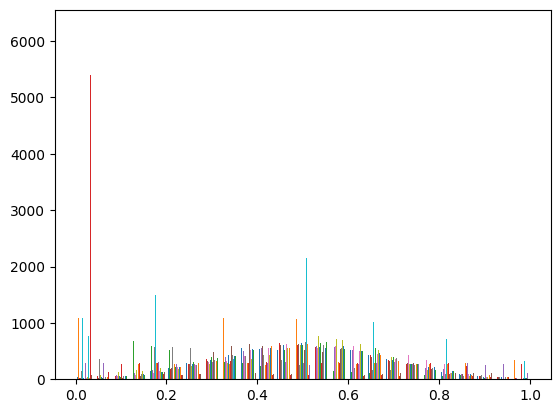

In [324]:
graph = pyplot.hist(X_scaled, bins=25)
graph.index

### Standard scaling

We use standard scaling to make the data more Gaussian like, but the extreme values will still persisit, this will have to be fixed in the next step.

<function tuple.index(value, start=0, stop=9223372036854775807, /)>

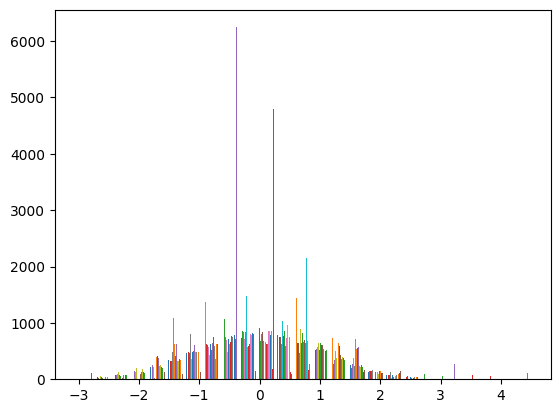

In [325]:
# scaler = RobustScaler()
# X_scaled = scaler.fit_transform(X_scaled) 
# pyplot.hist(X_scaled, bins=25)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_scaled)
graph = pyplot.hist(X_scaled, bins=25)
graph.index


### Making data distribution more normal

<function tuple.index(value, start=0, stop=9223372036854775807, /)>

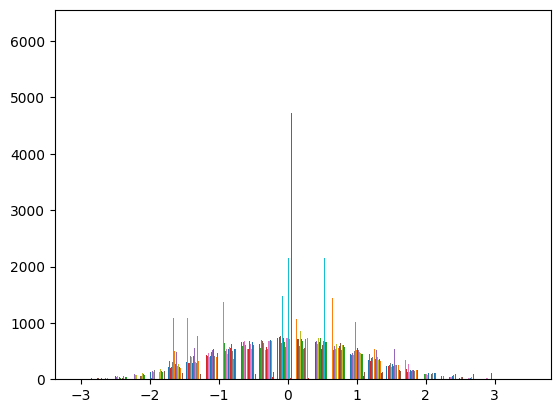

In [326]:
power = PowerTransformer(method='yeo-johnson', standardize=True) 
X_new = power.fit_transform(X_scaled)
graph = pyplot.hist(X_new, bins=25)
graph.index

We can see on the graph that there are big extreme values on the side, we want to make our data more uniform using the PowerTransformaer and the yeo-johnson method. This will make the distribution of our data more Gaussian.

### Quantile transform

<!-- We are going to use QuantileTransform to reduce the skewness of the original data. This method also helps handlig outliers by making extreme values less influential. -->

In [327]:
# selector = VarianceThreshold(threshold=(1.0))
# pyplot.hist(X_new, bins=5)
# X_new = selector.fit_transform(X_new)
# qt = QuantileTransformer(n_quantiles=10, random_state=0)
# X_new = qt.fit_transform(X_scaled)
# pyplot.hist(X_new, bins=25)


### Feature selection using SelectFromModel - **mozno uz tvoja cast**

In [328]:
selector = SelectFromModel(estimator=LogisticRegression()).fit(X_new, y_train)
print(selector.estimator_.coef_)
print(selector.threshold_)
print(selector.get_support())

X_new = selector.transform(X_new)
X_new

[[-2.39747901e-02 -1.61966551e-02  1.39387118e-01  6.12953119e-03
   6.04900032e-02  2.31918179e-03 -1.27068737e-01 -3.15409566e-02
   4.51173295e-01 -3.95678928e-02 -5.40546694e-01 -5.29267697e-03
  -2.28347620e+00 -1.93693177e-02  1.94551240e-02  2.62786769e+00
   2.46567811e+00 -2.64390610e-02  2.00248544e-01 -1.11434539e-02
   1.98687112e-02  5.29763099e-02 -2.13571214e-01  2.28099571e-03
   3.11695893e-03 -2.78679535e-02]]
0.36219412204237184
[False False False False False False False False  True False  True False
  True False False  True  True False False False False False False False
 False False]


array([[-1.41737105,  1.34130581, -1.1516285 , -0.38259503, -1.18448559],
       [ 0.4205329 , -0.806331  , -0.24042241,  0.53410142, -0.18128025],
       [ 0.56260223, -0.73751623, -1.00890353, -0.80724097, -0.14381724],
       ...,
       [ 0.05417485,  0.23706616,  0.51361346,  0.5376555 , -0.81473286],
       [-1.70517415,  0.58431827,  0.64687646,  0.47194313, -0.31056086],
       [ 0.0684742 , -0.62001361,  1.12608294, -0.98574043,  1.32213633]])